In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [29]:
# Reading the cleaned dataset
spot = pd.read_csv('spot.csv')
spot.head()

,id,artists,album,track,popularity,duration,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,class
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,C#,-6.746,Major,0.1430,0.0322,0.000001,0.3580,0.715,87.917,acoustic,popular
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,C#,-17.235,Minor,0.0763,0.9240,0.000006,0.1010,0.267,77.489,acoustic,popular
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,C,-9.734,Minor,0.0557,0.2100,0.000000,0.1170,0.120,76.332,acoustic,popular
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,C,-18.515,Minor,0.0363,0.9050,0.000071,0.1320,0.143,181.740,acoustic,popular
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,D,-9.681,Minor,0.0526,0.4690,0.000000,0.0829,0.167,119.949,acoustic,popular


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Defining features and target variable
spot['lduration'] = np.log(spot['duration'])
features = ['lduration', 'danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'liveness']
spot['class'] = np.where(spot['popularity'] >= 50, 0, 1)

X = spot[features]
y = spot['class']

# Encoding the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train-test split, oversampling for class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=3)
smote = SMOTE(random_state=3)
X_os, y_os = smote.fit_resample(X_train, y_train)

# Standardizing the features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_os)
X_test_s = scaler.transform(X_test)

In [32]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc

# Setting a baseline for comparison
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_s, y_os)
y_pred_dummy = dummy.predict(X_test_s)

print("Dummy Classifier Accuracy:", round((accuracy_score(y_test, y_pred_dummy) * 100), 2))

Dummy Classifier Accuracy: 30.33


Logistic Regression
              precision    recall  f1-score   support

           0       0.38      0.64      0.48      5728
           1       0.78      0.55      0.65     13159

    accuracy                           0.58     18887
   macro avg       0.58      0.60      0.56     18887
weighted avg       0.66      0.58      0.60     18887



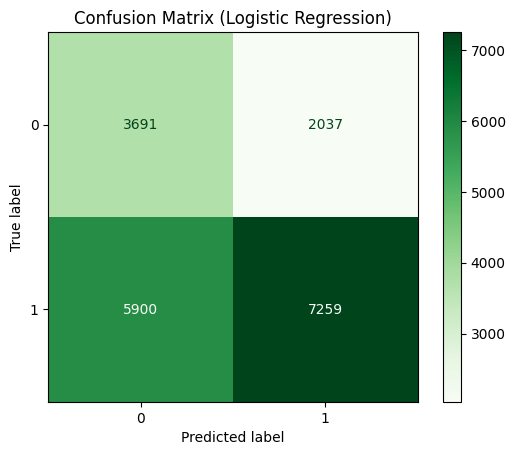

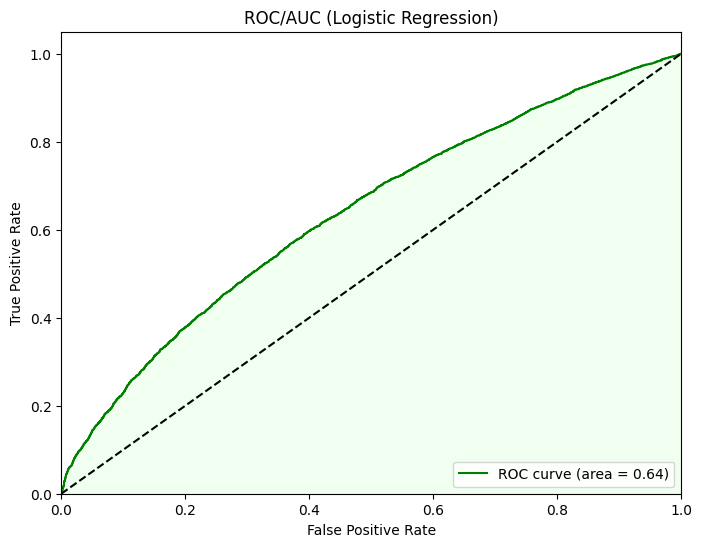

K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.53      0.71      0.60      5728
           1       0.85      0.72      0.78     13159

    accuracy                           0.72     18887
   macro avg       0.69      0.72      0.69     18887
weighted avg       0.75      0.72      0.73     18887



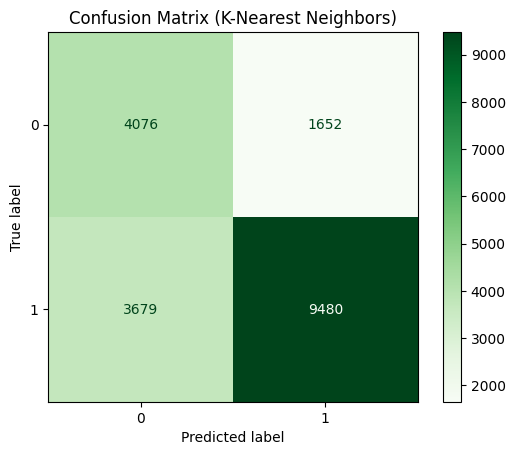

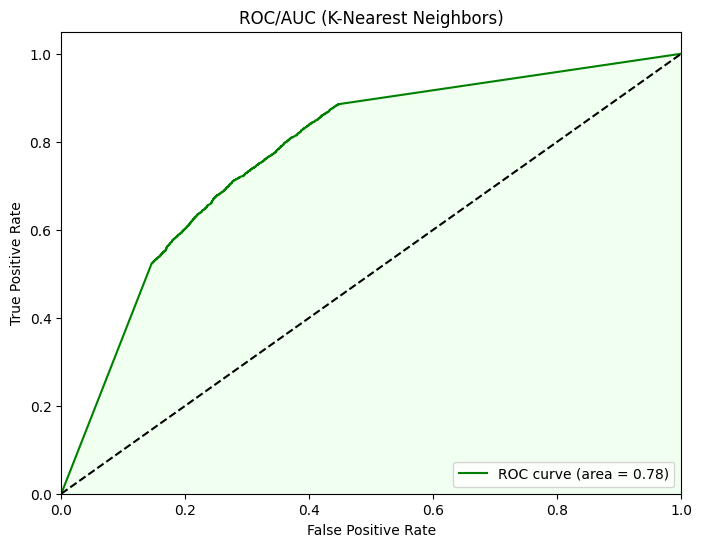

[13:14:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



XGBoost
              precision    recall  f1-score   support

           0       0.57      0.68      0.62      5728
           1       0.85      0.77      0.81     13159

    accuracy                           0.75     18887
   macro avg       0.71      0.73      0.71     18887
weighted avg       0.76      0.75      0.75     18887



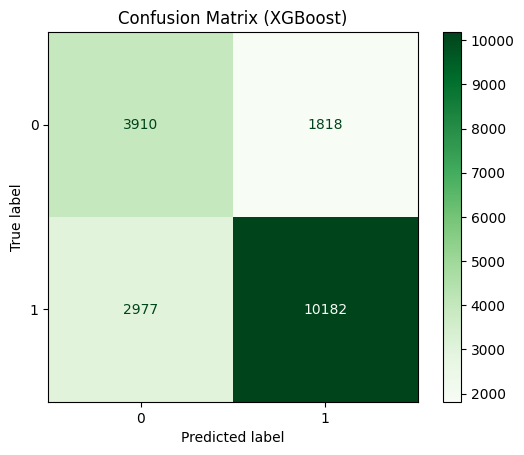

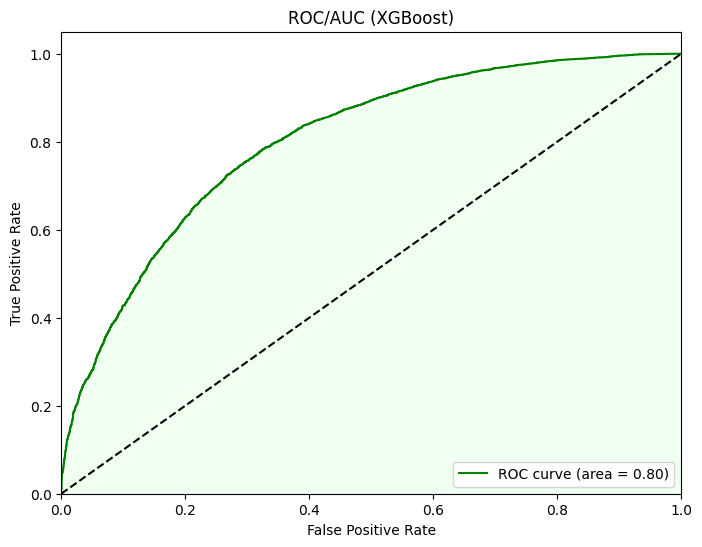

Random Forest
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      5728
           1       0.85      0.83      0.84     13159

    accuracy                           0.78     18887
   macro avg       0.74      0.74      0.74     18887
weighted avg       0.78      0.78      0.78     18887



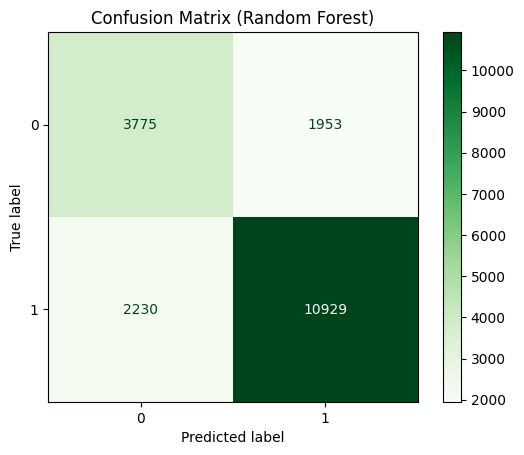

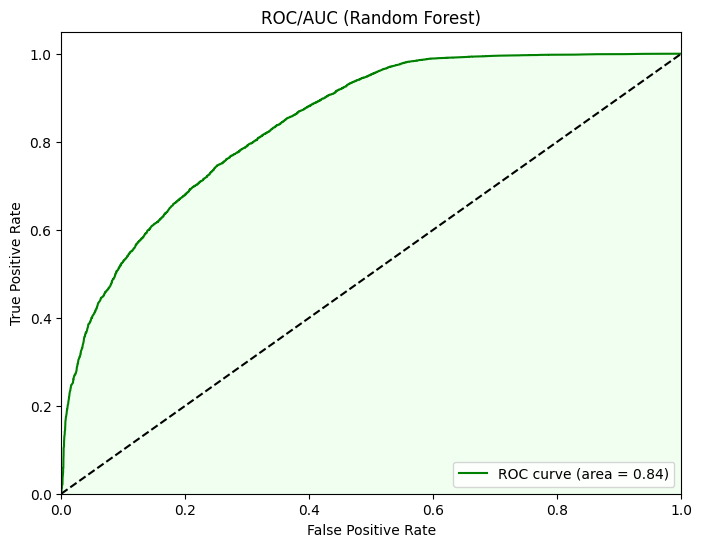

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Creating a loop to train and evaluate multiple classifiers (optimized using GridSearchCV)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3, weights='distance', p=1),
    'XGBoost': XGBClassifier(learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.8, use_label_encoder=False, eval_metric='logloss', random_state=3),
    'Random Forest': RandomForestClassifier(n_estimators=500, random_state=3)
}

for i in models:
    models[i].fit(X_train_s, y_os)
    y_pred = models[i].predict(X_test_s)
    print(f'{i}')
    print(classification_report(y_test, y_pred))

    # Plotting confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Greens, values_format='d')
    plt.title(f'Confusion Matrix ({i})')
    plt.savefig('confusion_matrix.png', bbox_inches='tight')
    plt.show()
    # Plotting ROC curve
    fpr, tpr, _ = roc_curve(y_test, models[i].predict_proba(X_test_s)[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='green', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.fill_between(fpr, tpr, alpha=0.1, color='#7CFF7C')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC/AUC ({i})')
    plt.legend(loc='lower right')
    plt.savefig('roc_curve.png', bbox_inches='tight')
    plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid search for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=3), rf_param_grid, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_grid.fit(X_train_s, y_os)

print(f'Random Forest, best parameters: {rf_grid.best_params_}')
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test_s)
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [13]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
rf = models['Random Forest']

scores = cross_val_score(models['Random Forest'], X_train_s, y_os, cv=skf, scoring='roc_auc')

print("ROC/AUC", scores)
print("Mean:", scores.mean())

ROC/AUC [0.91354158 0.91358869 0.91503849 0.91369589 0.91359273]
Mean: 0.9138914752286903


In [22]:
# Downloading the Random Forest model for future validation
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(models['Random Forest'], 'rf_model.pkl')

['rf_model.pkl']

In [ ]:
# Grid search for K-Nearest Neighbors
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
knn_grid.fit(X_train_s, y_os)

print(f'K-Nearest Neighbors, best parameters: {knn_grid.best_params_}')
knn_best = knn_grid.best_estimator_
y_pred_knn = knn_best.predict(X_test_s)
print(classification_report(y_test, y_pred_knn))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (K-Nearest Neighbors)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Grid search for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=3), xgb_param_grid, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
xgb_grid.fit(X_train_s, y_os)

print(f'XGBoost, best parameters: {xgb_grid.best_params_}')
xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_test_s)
print(classification_report(y_test, y_pred_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

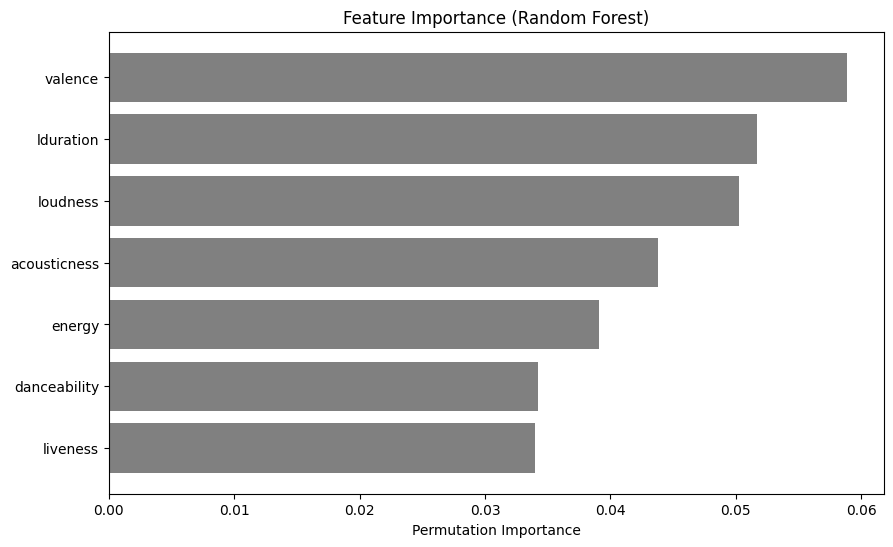

In [35]:
# Permutation feature importance
from sklearn.inspection import permutation_importance

permimp = permutation_importance(models['Random Forest'], X_test_s, y_test, n_repeats=30, random_state=3)
index = permimp.importances_mean.argsort()[:-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(index)), permimp.importances_mean[index], color='grey', align='center')
plt.yticks(range(len(index)), [features[i] for i in index])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Random Forest)')
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()